In [1]:
#mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install -q torchvision tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.9 MB/s eta 0:00:00


In [5]:
#Import neccessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

import torch
import torch.nn as nn
from torchvision import models, transforms
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

In [9]:
#Path to train and test dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_path = "/content/drive/MyDrive/tile/train/good"
test_path = "/content/drive/MyDrive/tile/test"

In [6]:
# Define transformers
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [7]:
# Create feature extractor using ResNet50
class FeatureEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.backbone.eval()
        for p in self.backbone.parameters():
            p.requires_grad = False

        self.features = []
        def hook_fn(_, __, output):
            self.features.append(output)

        self.backbone.layer2[-1].register_forward_hook(hook_fn)
        self.backbone.layer3[-1].register_forward_hook(hook_fn)

    def forward(self, x):
        self.features = []
        _ = self.backbone(x)

        pool = nn.AvgPool2d(3, stride=1)
        target_size = self.features[0].shape[-2:]
        adapt = nn.AdaptiveAvgPool2d(target_size)

        processed = [adapt(pool(f)) for f in self.features]
        concat = torch.cat(processed, dim=1)
        flat = concat.view(concat.size(1), -1).T
        return flat

In [10]:
#build model
model = FeatureEncoder().to(device)

In [11]:
#Build feature bank from good images
memory_bank = []

for img_file in tqdm(sorted(Path(train_path).glob("*.png"))):
    img = Image.open(img_file).convert("RGB")
    tensor = img_transform(img).unsqueeze(0).to(device)
    features = model(tensor)
    memory_bank.append(features.cpu())

memory_bank = torch.cat(memory_bank, dim=0).to(device)
print("Memory bank shape:", memory_bank.shape)

100%|██████████| 230/230 [02:14<00:00,  1.71it/s]


Memory bank shape: torch.Size([180320, 1536])


In [12]:
#Set threshold using anomaly scores of good images
train_scores = []

for img_file in tqdm(sorted(Path(train_path).glob("*.png"))):
    img = Image.open(img_file).convert("RGB")
    tensor = img_transform(img).unsqueeze(0).to(device)
    feature = model(tensor)
    dist = torch.cdist(feature, memory_bank)
    score = torch.max(torch.min(dist, dim=1).values)
    train_scores.append(score.item())

mean_score = np.mean(train_scores)
std_score = np.std(train_scores)
threshold = mean_score + 3 * std_score
print(f"Threshold: {threshold:.4f}")

100%|██████████| 230/230 [44:35<00:00, 11.63s/it]

Threshold: 0.0032


In [13]:
#Evaluate on test dataset
y_true = []
y_score = []

for class_dir in sorted(os.listdir(test_path)):
    full_class_path = Path(test_path) / class_dir

    for img_file in full_class_path.glob("*.png"):
        img = Image.open(img_file).convert("RGB")
        tensor = img_transform(img).unsqueeze(0).to(device)
        feature = model(tensor)
        dist = torch.cdist(feature, memory_bank)
        score = torch.max(torch.min(dist, dim=1).values)

        y_score.append(score.item())
        y_true.append(0 if class_dir == "good" else 1)

In [14]:
#Metrics calculation using F1 score and AUC
y_true = np.array(y_true)
y_score = np.array(y_score)

auc = roc_auc_score(y_true, y_score)
fpr, tpr, thresholds = roc_curve(y_true, y_score)
f1s = [f1_score(y_true, y_score >= th) for th in thresholds]
best_thresh = thresholds[np.argmax(f1s)]

print(f"AUC-ROC: {auc:.4f}")
print(f"Best Threshold (F1): {best_thresh:.4f}")

AUC-ROC: 0.9953
Best Threshold (F1): 1.5630


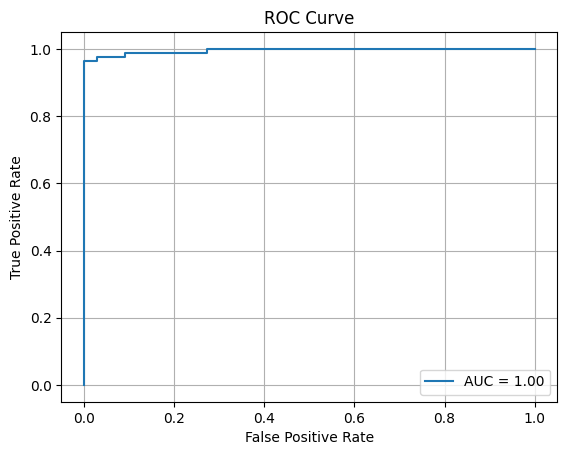

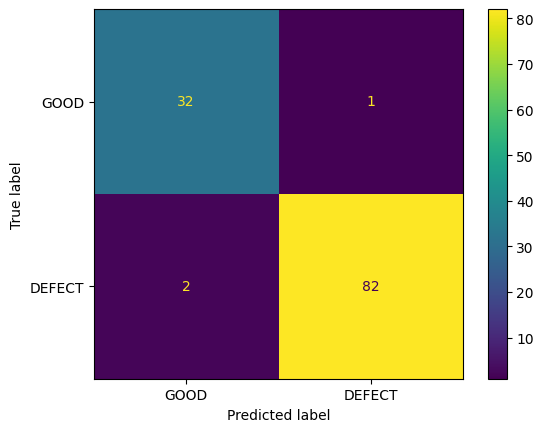

In [15]:
#Plot perfomance metrics
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid()
plt.legend()
plt.show()

y_pred = (y_score >= best_thresh).astype(int)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["GOOD", "DEFECT"])
disp.plot()
plt.show()

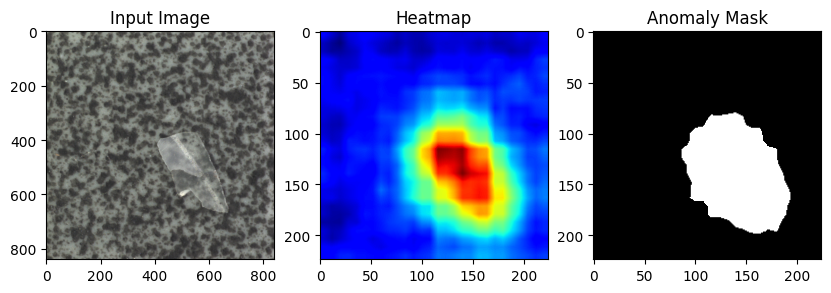

In [21]:
#Visualize a sample anomaly detection heatmap
sample = "/content/drive/MyDrive/tile/test/glue_strip/000.png"
img = Image.open(sample).convert("RGB")
tensor = img_transform(img).unsqueeze(0).to(device)
features = model(tensor)
dist = torch.cdist(features, memory_bank)
dist_map = torch.min(dist, dim=1).values.view(1, 1, 28, 28)
upsampled = torch.nn.functional.interpolate(dist_map, size=(224, 224), mode='bilinear')
heatmap = upsampled.squeeze().cpu().numpy()

plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.imshow(np.array(img))
plt.title("Input Image")

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap="jet")
plt.title("Heatmap")

plt.subplot(1, 3, 3)
plt.imshow(heatmap > best_thresh, cmap="gray")
plt.title("Anomaly Mask")

plt.show()